In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import xarray as xr
import cmocean.cm as cmocean
import glob
import matplotlib.path as mpath
import matplotlib.colors as col
from netCDF4 import Dataset
from mpl_toolkits.axes_grid1 import make_axes_locatable


import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

figdir = '/g/data/e14/pc5520/figures/basal_melt_param/'

In [2]:
client = Client()
client

<Client: 'tcp://127.0.0.1:43799' processes=5 threads=20, memory=128.00 GiB>

In [3]:
# database for control simulation:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
control = '01deg_jra55v13_ryf9091'

# database for perturbations:
basal_session = cc.database.create_session('/g/data/v45/akm157/model_data/access-om2/01deg_jra55v13_ryf9091_easterlies_up10/easterlies.db')
# 10% increase in easterly wind speed:
easterlies_up = '01deg_jra55v13_ryf9091_easterlies_up10'
# 10% decrease in easterly wind speed:
easterlies_down = '01deg_jra55v13_ryf9091_easterlies_down10'

In [4]:
master_session = cc.database.create_session()

control = '01deg_jra55v13_ryf9091'

Tfreezing_min_calv_2 = 'accessom2-GPC013'
# idem as GPC013 but gade line formulation
Tfreezing_min_calv_2_gade = 'accessom2-GPC015'

start_time='2159-01-01'
end_time='2160-01-01'

lat_slice  = slice(-80,-59)

depthlim = 1500

In [5]:
# build database for these experiments:
session_name = '/g/data/e14/pc5520/model_data/access-om2/basal_melt_MOM5/basal_melt_MOM5.db'
basal_melt_session = cc.database.create_session(session_name)

dir_list = ['/g/data/e14/pc5520/access-om2/archive/01deg_jra55v13_ryf9091_rerun_for_easterlies/accessom2-GPC013/',
           '/g/data/ik11/outputs/access-om2-01/basal_melt_outputs/accessom2-GPC015/accessom2-GPC015/']
cc.database.build_index(dir_list,basal_melt_session)

Indexing experiment: accessom2-GPC013


0it [00:00, ?it/s]


Indexing experiment: accessom2-GPC015


0it [00:00, ?it/s]


0

In [6]:
# topography data for plotting:
ht = cc.querying.getvar(control,'ht' , master_session,n=1).sel(yt_ocean=lat_slice)
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)
land_mask_masked = np.ma.masked_where((land_mask==0),land_mask)
# make land go all the way to -90S:
land_mask_lat = ht.yt_ocean.values
land_mask_lat[0] = -90

fontsize=15

In [7]:
# First plot map of bottom temperature to see where we want to plot transects

In [8]:
start_time='2155-01-01'
end_time='2156-01-01'

temp_con = cc.querying.getvar(control, 'temp', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_con = temp_con.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
temp_con = temp_con.mean('time')

temp_Tfreezing_min_calv_2 = cc.querying.getvar(Tfreezing_min_calv_2, 'temp', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_Tfreezing_min_calv_2 = temp_Tfreezing_min_calv_2.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
temp_Tfreezing_min_calv_2 = temp_Tfreezing_min_calv_2.mean('time')

In [9]:
# select out bottom values:
depth_array = temp_con * 0 + temp_con.st_ocean
max_depth = depth_array.max(dim = 'st_ocean', skipna= True)

bottom_temp_con = temp_con.where(depth_array.st_ocean >= max_depth)
bottom_temp_con = bottom_temp_con.sum(dim = 'st_ocean')
bottom_temp_con = bottom_temp_con.load()

bottom_temp_Tfreezing_min_calv_2 = temp_Tfreezing_min_calv_2.where(depth_array.st_ocean >= max_depth)
bottom_temp_Tfreezing_min_calv_2 = bottom_temp_Tfreezing_min_calv_2.sum(dim = 'st_ocean')
bottom_temp_Tfreezing_min_calv_2 = bottom_temp_Tfreezing_min_calv_2.load()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice 

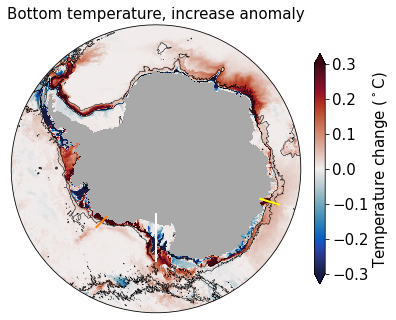

In [10]:
scale_max = 0.3

fig  = plt.figure(1, figsize = (10,8))
norm = col.Normalize(vmin=-scale_max,vmax=scale_max)

# up:
# setup stereo projection:
ax = fig.add_axes([0.0, 0.5, 0.5, 0.5],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
# plot:
cf = ax.pcolormesh(bottom_temp_con.xt_ocean, bottom_temp_con.yt_ocean, bottom_temp_Tfreezing_min_calv_2-bottom_temp_con, norm = norm, 
                   cmap = cmocean.balance, transform = ccrs.PlateCarree())
ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('Bottom temperature, increase anomaly',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
             zorder=2,transform = ccrs.PlateCarree())

# Add transect lines:
#Ross
plt.plot([-180,-180],[-80,-70],'white',linewidth=2,transform = ccrs.PlateCarree())
#WedellE
#plt.plot([-57,-57],[-80,-70],'k',linewidth=2,transform = ccrs.PlateCarree())
#WedellW
#plt.plot([-40,-40],[-80,-70],'k',linewidth=2,transform = ccrs.PlateCarree())
# AmundsenE:
#plt.plot([-107,-107],[-75,-70],'C1',linewidth=2,transform = ccrs.PlateCarree())
# AmundsenW:
plt.plot([-135,-135],[-75,-72],'C1',linewidth=2,transform = ccrs.PlateCarree())
# warm patch just downstream of Mertz:
#plt.plot([-220,-220],[-68,-64],'m',linewidth=2,transform = ccrs.PlateCarree())
# cooling in Totten:
#plt.plot([-242,-242],[-67.5,-64],'green',linewidth=2,transform = ccrs.PlateCarree())
# cold patch in Vincennes Bay:
plt.plot([-253,-253],[-67,-63],'yellow',linewidth=2,transform = ccrs.PlateCarree())
# warm patch downstream of PrydzE:
#plt.plot([60,60],[-69,-64],'orange',linewidth=2,transform = ccrs.PlateCarree())
# warm patch downstream of PrydzW:
#plt.plot([35.5,35.5],[-71,-64],'orange',linewidth=2,transform = ccrs.PlateCarree())
        
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# colorbar:
cbaxes = fig.add_axes([0.47, 0.55, 0.015, 0.4])
cbar = plt.colorbar(cf, cax = cbaxes, orientation = 'vertical',extend = 'both')
cbar.set_label(r'Temperature change ($^\circ$C)',fontsize=fontsize,labelpad=2)
cbar.ax.tick_params(labelsize=fontsize)

#figure_path = figdir+'map_bottom_temp_with_transect_locations.png'
#plt.savefig(figure_path, dpi=120,bbox_inches='tight', pad_inches=0.1,facecolor='white')

In [11]:
#Temperature transects

In [7]:
zlevel1 = 0
zlevel2 = depthlim + 100

first_year = '2159'
last_year = '2160'

start_time=first_year+'-01-01'
end_time=last_year+'-01-01'

def get_transect_data(lon,lat1,lat2):
    lat_slice  = slice(lat1, lat2)

    # import bathymetry:
    ht_transect = cc.querying.getvar(control,'ht',master_session,n=1)
    ht_transect = ht_transect.sel(xt_ocean=lon,method='nearest').sel(yt_ocean=lat_slice)
    ht_transect = ht_transect.load()
    ht_transect[np.isnan(ht_transect)] = 0

    ### load data for this period:
    temp_con_transect = cc.querying.getvar(control,'temp' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
    temp_con_transect = temp_con_transect.sel(xt_ocean=lon,method='nearest').sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time)).sel(st_ocean=slice(zlevel1,zlevel2)).mean('time')
    temp_con_transect = temp_con_transect.load()

    ### load data for this period:
    salt_con_transect = cc.querying.getvar(control,'salt' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time)
    salt_con_transect = salt_con_transect.sel(xt_ocean=lon,method='nearest').sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time)).sel(st_ocean=slice(zlevel1,zlevel2)).mean('time')
    salt_con_transect = salt_con_transect.load()
    
    ### load data for this period:
    age_con_transect = cc.querying.getvar(control,'age_global' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time)
    age_con_transect = age_con_transect.sel(xt_ocean=lon,method='nearest').sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time)).sel(st_ocean=slice(zlevel1,zlevel2)).mean('time')
    age_con_transect = age_con_transect.load()

    ### load data for this period:
    u_con_transect = cc.querying.getvar(control,'u' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time)
    u_con_transect = u_con_transect.sel(xu_ocean=lon,method='nearest').sel(yu_ocean=lat_slice).sel(time=slice(start_time,end_time)).sel(st_ocean=slice(zlevel1,zlevel2)).mean('time')
    u_con_transect = u_con_transect.load()
    
    ### also get density for plotting isopycnals:
    rho0_con = cc.querying.getvar(control,'pot_rho_0' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time)
    rho0_con = rho0_con.sel(xt_ocean=lon,method='nearest').sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time)).sel(st_ocean=slice(zlevel1,zlevel2)).mean('time')
    rho0_con = rho0_con.load()
    
    return ht_transect,temp_con_transect,salt_con_transect,age_con_transect,u_con_transect,rho0_con


In [8]:
zlevel1 = 0
zlevel2 = depthlim + 100

first_year = '2159'
last_year = '2160'

start_time=first_year+'-01-01'
end_time=last_year+'-01-01'

def get_transect_extra_data(lon,lat1,lat2,extrasim):
    lat_slice  = slice(lat1, lat2)

    # import bathymetry:
    ht_transect = cc.querying.getvar(control,'ht',master_session,n=1)
    ht_transect = ht_transect.sel(xt_ocean=lon,method='nearest').sel(yt_ocean=lat_slice)
    ht_transect = ht_transect.load()
    ht_transect[np.isnan(ht_transect)] = 0
    
    temp_extra_transect = cc.querying.getvar(extrasim, 'temp', basal_melt_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
    temp_extra_transect = temp_extra_transect.sel(xt_ocean=lon,method='nearest').sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time)).sel(st_ocean=slice(zlevel1,zlevel2)).mean('time')
    temp_extra_transect = temp_extra_transect.load()
    
    salt_extra_transect = cc.querying.getvar(extrasim, 'salt', basal_melt_session,frequency='1 monthly',start_time=start_time, end_time=end_time)
    salt_extra_transect = salt_extra_transect.sel(xt_ocean=lon,method='nearest').sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time)).sel(st_ocean=slice(zlevel1,zlevel2)).mean('time')
    salt_extra_transect = salt_extra_transect.load()
    
    age_extra_transect = cc.querying.getvar(extrasim, 'age_global', basal_melt_session,frequency='1 monthly',start_time=start_time, end_time=end_time)
    age_extra_transect = age_extra_transect.sel(xt_ocean=lon,method='nearest').sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time)).sel(st_ocean=slice(zlevel1,zlevel2)).mean('time')
    age_extra_transect = age_extra_transect.load()
    
    u_extra_transect = cc.querying.getvar(extrasim, 'u', basal_melt_session,frequency='1 monthly',start_time=start_time, end_time=end_time)
    u_extra_transect = u_extra_transect.sel(xu_ocean=lon,method='nearest').sel(yu_ocean=lat_slice).sel(time=slice(start_time,end_time)).sel(st_ocean=slice(zlevel1,zlevel2)).mean('time')
    u_extra_transect = u_extra_transect.load()
    
    rho0_extra = cc.querying.getvar(extrasim, 'pot_rho_0', basal_melt_session,frequency='1 monthly',start_time=start_time, end_time=end_time)
    rho0_extra = rho0_extra.sel(xt_ocean=lon,method='nearest').sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time)).sel(st_ocean=slice(zlevel1,zlevel2)).mean('time')
    rho0_extra = rho0_extra.load()
    
    #Import basal melt
    basal_Tfreezing_min_calv_2 = cc.querying.getvar(extrasim, 'basal_fwflx', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
    basal_Tfreezing_min_calv_2 = basal_Tfreezing_min_calv_2.sel(xt_ocean=lon,method='nearest').sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time)).sel(st_ocean=slice(zlevel1,zlevel2)).mean('time')
    basal_Tfreezing_min_calv_2 = basal_Tfreezing_min_calv_2.load()
    
    return ht_transect,temp_extra_transect,salt_extra_transect,age_extra_transect,u_extra_transect,rho0_extra,basal_Tfreezing_min_calv_2

In [20]:
def plot_transects(region):

    if region == 'AmundsenW':
        lon = -135
        lat1 = -74.7
        lat2 = -73
    elif region == 'AmundsenE':
        lon = -107
        lat1 = -75
        lat2 = -70
    elif region == 'Mertz':
        lon = -220
        lat1 = -66.8
        lat2 = -64.5
    elif region == 'Totten':
        lon = -242
        lat1 = -67.2
        lat2 = -64
    elif region == 'Vincennes':
        lon = -253
        lat1 = -67
        lat2 = -63
    elif region == 'PrydzE':
        lon = 60
        lat1 = -67.5
        lat2 = -64    
    elif region == 'PrydzW':
        lon = 35.5
        lat1 = -69.5
        lat2 = -66 
    elif region == 'WedellE':
        lon = -57
        lat1 = -80
        lat2 = -70
    elif region == 'WedellW':
        lon = -40
        lat1 = -80
        lat2 = -70
    elif region == 'Ross':
        lon = -180
        lat1 = -80
        lat2 = -70

    ht_transect,temp_con_transect,salt_con_transect,age_con_transect,u_con_transect,rho0_con = get_transect_data(lon,lat1,lat2+.1)
    
    #extrasim = Tfreezing_min_calv_2
    #ht_transect2,temp_extra_transect,salt_extra_transect,age_extra_transect,u_extra_transect,rho0_extra,basal_extra = get_transect_extra_data(lon,lat1,lat2+.1,extrasim)
    #temp_Tfreezing_min_transect,salt_Tfreezing_min_transect,age_Tfreezing_min_transect,u_Tfreezing_min_transect,rho0_Tfreezing_min,basal_Tfreezing_min = temp_extra_transect,salt_extra_transect,age_extra_transect,u_extra_transect,rho0_extra,basal_extra
    
    extrasim2 = Tfreezing_min_calv_2_gade
    ht_transect3,temp_extra_transect2,salt_extra_transect2,age_extra_transect2,u_extra_transect2,rho0_extra2,basal_extra2 = get_transect_extra_data(lon,lat1,lat2+.1,extrasim2)
    temp_gade_transect,salt_gade_transect,age_gade_transect,u_gade_transect,rho0_gade,basal_gade = temp_extra_transect2,salt_extra_transect2,age_extra_transect2,u_extra_transect2,rho0_extra2,basal_extra2

    ####
    
    
    ylimit = depthlim
    
    fontsize=16

    fig=plt.figure(figsize=(20,32))

    scale_max = 0.4

    density_contours = [1027.5,1027.6,1027.72,1027.78,1027.81,1027.83,1027.835,1027.84,1027.845,1027.85]
    
    #####################################################################################################

    #### heat bal - con:
    plt.subplot(4,3,1)
    norm = col.Normalize(vmin=-.2,vmax=.2)
    levels=np.arange(-.2,.205,.005)
    ticks = [-0.2,-.1,0,.1,.2]

    pcm = plt.contourf(temp_con_transect.yt_ocean,temp_con_transect.st_ocean,
                       temp_con_transect.interpolate_na(dim='st_ocean',method='nearest',fill_value='extrapolate'),
                       cmap = cmocean.cm.jet, norm = norm,levels=levels,extend='both')
    plt.fill_between(temp_con_transect.yt_ocean,ht_transect,ylimit,zorder=3,color='darkgrey')
    plt.ylim(ylimit,0)
    plt.xlim(lat1,lat2)
    plt.ylabel('Depth (m)',fontsize=fontsize)
    plt.xlabel('Latitude',fontsize=fontsize)
    plt.tick_params(labelsize=fontsize)

    # isopycnals:
    cont=plt.contour(rho0_con.yt_ocean,rho0_con.st_ocean,rho0_con,density_contours,
                      colors='k',zorder=2 ,fontsize=fontsize)
    
    plt.title('Basal_Heat_Bal - Control',fontsize=fontsize)


    # colorbar:
    ax = plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="4%", pad=0.8)
    cbar = plt.colorbar(pcm, cax=cax,orientation = 'horizontal',extend = 'neither',ticks=ticks)
    cbar.set_label(r'Temperature anomaly ($^\circ$C)',fontsize=fontsize,labelpad=5)
    cbar.ax.tick_params(labelsize=fontsize)
    
    #### gade - con:
    plt.subplot(4,3,2)
    norm = col.Normalize(vmin=-.2,vmax=.2)
    levels=np.arange(-.2,.205,.005)
    ticks = [-0.2,-.1,0,.1,.2]

    pcm = plt.contourf(temp_con_transect.yt_ocean,temp_con_transect.st_ocean,
                       temp_gade_transect.interpolate_na(dim='st_ocean',method='nearest',fill_value='extrapolate'),
                       cmap = cmocean.cm.jet, norm = norm,levels=levels,extend='both')
    plt.fill_between(temp_gade_transect.yt_ocean,ht_transect,ylimit,zorder=3,color='darkgrey')
    plt.ylim(ylimit,0)
    plt.xlim(lat1,lat2)
    plt.ylabel('Depth (m)',fontsize=fontsize)
    plt.xlabel('Latitude',fontsize=fontsize)
    plt.tick_params(labelsize=fontsize)

    # isopycnals:
    cont=plt.contour(rho0_con.yt_ocean,rho0_con.st_ocean,rho0_gade,density_contours,
                      colors='k',zorder=2 ,fontsize=fontsize,linestyles='--')
    
    plt.title('Basal_Gade - Control',fontsize=fontsize)


    # colorbar:
    ax = plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="4%", pad=0.8)
    cbar = plt.colorbar(pcm, cax=cax,orientation = 'horizontal',extend = 'neither',ticks=ticks)
    cbar.set_label(r'Temperature anomaly ($^\circ$C)',fontsize=fontsize,labelpad=5)
    cbar.ax.tick_params(labelsize=fontsize)


    #### gade - heat bal:
    plt.subplot(4,3,3)
    norm = col.Normalize(vmin=-.2,vmax=.2)
    levels=np.arange(-.2,.205,.005)
    #ticks = [-.4,-.2,0,.2,.4]
    ticks = [-0.2,-.1,0,.1,.2]
    pcm = plt.contourf(temp_con_transect.yt_ocean,temp_con_transect.st_ocean,
                       (temp_gade_transect.interpolate_na(dim='st_ocean',method='nearest',fill_value='extrapolate')-\
                       temp_con_transect.interpolate_na(dim='st_ocean',method='nearest',fill_value='extrapolate')),
                       cmap = cmocean.balance, norm = norm,levels=levels,extend='both')
    plt.fill_between(temp_con_transect.yt_ocean,ht_transect,ylimit,zorder=3,color='darkgrey')
    plt.ylim(ylimit,0)
    plt.xlim(lat1,lat2)
    plt.xlabel('Latitude',fontsize=fontsize)
    plt.tick_params(labelsize=fontsize)

    # isopycnals:
    cont=plt.contour(rho0_con.yt_ocean,rho0_con.st_ocean,rho0_gade,density_contours,
                      colors='k',zorder=2 ,fontsize=fontsize,linestyles='--')
    cont=plt.contour(rho0_con.yt_ocean,rho0_con.st_ocean,rho0_con,density_contours,
                      colors='k',zorder=2 ,fontsize=fontsize)

    #plt.title(region+', longitude='+str(lon),fontsize=fontsize)
    plt.title('Basal_Gade - Basal_Heat_bal',fontsize=fontsize)
    
    # colorbar:
    ax = plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="4%", pad=0.8)
    cbar = plt.colorbar(pcm, cax=cax,orientation = 'horizontal',extend = 'neither',ticks=ticks)
    cbar.set_label(r'Temperature anomaly ($^\circ$C)',fontsize=fontsize,labelpad=5)
    cbar.ax.tick_params(labelsize=fontsize)
    
    #####################################################################################################
    
    #### Control salt:
    plt.subplot(4,3,4)
    norm = col.Normalize(vmin=-33,vmax=35)
    levels=np.arange(-.1,.101,.001)
    ticks = [-.1,-.05,0,.05,.1]

    pcm = plt.contourf(salt_con_transect.yt_ocean,salt_con_transect.st_ocean,
                       salt_con_transect.interpolate_na(dim='st_ocean',method='nearest',fill_value='extrapolate'),
                       cmap = cmocean.cm.jet, norm = norm,levels=levels,extend='both')
    plt.fill_between(salt_con_transect.yt_ocean,ht_transect,ylimit,zorder=3,color='darkgrey')
    plt.ylim(ylimit,0)
    plt.xlim(lat1,lat2)
    plt.ylabel('Depth (m)',fontsize=fontsize)
    plt.xlabel('Latitude',fontsize=fontsize)
    plt.tick_params(labelsize=fontsize)

    # isopycnals:
    cont=plt.contour(rho0_con.yt_ocean,rho0_con.st_ocean,rho0_con,density_contours,
                      colors='k',zorder=2 ,fontsize=fontsize)
    plt.title('Basal_Heat_Bal - Control',fontsize=fontsize)

    # colorbar:
    ax = plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="4%", pad=0.8)
    cbar = plt.colorbar(pcm, cax=cax,orientation = 'horizontal',extend = 'neither',ticks=ticks)
    cbar.set_label(r'Salinity anomaly',fontsize=fontsize,labelpad=5)
    cbar.ax.tick_params(labelsize=fontsize)
    
    #### Tfreezing_min salt:
    plt.subplot(4,3,5)
    norm = col.Normalize(vmin=33,vmax=35)
    levels=np.arange(-.1,.101,.001)
    ticks = [-.1,-.05,0,.05,.1]

    pcm = plt.contourf(salt_con_transect.yt_ocean,salt_con_transect.st_ocean,
                       salt_gade_transect.interpolate_na(dim='st_ocean',method='nearest',fill_value='extrapolate'),
                       cmap = cmocean.cm.jet, norm = norm,levels=levels,extend='both')
    plt.fill_between(salt_con_transect.yt_ocean,ht_transect,ylimit,zorder=3,color='darkgrey')
    plt.ylim(ylimit,0)
    plt.xlim(lat1,lat2)
    plt.ylabel('Depth (m)',fontsize=fontsize)
    plt.xlabel('Latitude',fontsize=fontsize)
    plt.tick_params(labelsize=fontsize)

    # isopycnals:
    cont=plt.contour(rho0_con.yt_ocean,rho0_con.st_ocean,rho0_gade,density_contours,
                      colors='k',zorder=2 ,fontsize=fontsize,linestyles='--')
    plt.title('Basal_Gade - Control',fontsize=fontsize)

    # colorbar:
    ax = plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="4%", pad=0.8)
    cbar = plt.colorbar(pcm, cax=cax,orientation = 'horizontal',extend = 'neither',ticks=ticks)
    cbar.set_label(r'Salinity anomaly',fontsize=fontsize,labelpad=5)
    cbar.ax.tick_params(labelsize=fontsize)


    #### Tfreezing_min salt diff:
    plt.subplot(4,3,6)
    norm = col.Normalize(vmin=-.1,vmax=.1)
    levels=np.arange(-.1,.101,.001)
    ticks = [-.1,-.05,0,.05,.1]
    pcm = plt.contourf(salt_con_transect.yt_ocean,salt_con_transect.st_ocean,
                       (salt_gade_transect.interpolate_na(dim='st_ocean',method='nearest',fill_value='extrapolate')-\
                       salt_con_transect.interpolate_na(dim='st_ocean',method='nearest',fill_value='extrapolate')),
                       cmap = cmocean.balance, norm = norm,levels=levels,extend='both')
    plt.fill_between(salt_con_transect.yt_ocean,ht_transect,ylimit,zorder=3,color='darkgrey')
    plt.ylim(ylimit,0)
    plt.xlim(lat1,lat2)
    plt.xlabel('Latitude',fontsize=fontsize)
    plt.tick_params(labelsize=fontsize)

    # isopycnals:
    cont=plt.contour(rho0_con.yt_ocean,rho0_con.st_ocean,rho0_gade,density_contours,
                      colors='k',zorder=2 ,fontsize=fontsize,linestyles='--')
    cont=plt.contour(rho0_con.yt_ocean,rho0_con.st_ocean,rho0_con,density_contours,
                      colors='k',zorder=2 ,fontsize=fontsize)
    
    plt.title('Basal_Gade - Basal_Heat_Bal',fontsize=fontsize)


    # colorbar:
    ax = plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="4%", pad=0.8)
    cbar = plt.colorbar(pcm, cax=cax,orientation = 'horizontal',extend = 'neither',ticks=ticks)
    cbar.set_label(r'Salinity anomaly',fontsize=fontsize,labelpad=5)
    cbar.ax.tick_params(labelsize=fontsize)
    
    #####################################################################################################
    
    #### Control age:
    plt.subplot(4,3,7)
    norm = col.Normalize(vmin=0,vmax=200)
    levels=np.arange(-10,10,0.1)
    ticks = [-10,-5,0,5,10]

    pcm = plt.contourf(age_con_transect.yt_ocean,age_con_transect.st_ocean,
                       age_con_transect.interpolate_na(dim='st_ocean',method='nearest',fill_value='extrapolate'),
                       cmap = cmocean.cm.jet, norm = norm,levels=levels,extend='both')
    plt.fill_between(salt_con_transect.yt_ocean,ht_transect,ylimit,zorder=3,color='darkgrey')
    plt.ylim(ylimit,0)
    plt.xlim(lat1,lat2)
    plt.ylabel('Depth (m)',fontsize=fontsize)
    plt.xlabel('Latitude',fontsize=fontsize)
    plt.tick_params(labelsize=fontsize)

    # isopycnals:
    cont=plt.contour(rho0_con.yt_ocean,rho0_con.st_ocean,rho0_con,density_contours,
                      colors='k',zorder=2 ,fontsize=fontsize)
    plt.title('Basal_Heat_Bal - Control',fontsize=fontsize)

    # colorbar:
    ax = plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="4%", pad=0.8)
    cbar = plt.colorbar(pcm, cax=cax,orientation = 'horizontal',extend = 'neither',ticks=ticks)
    cbar.set_label(r'Age anomaly (yr)',fontsize=fontsize,labelpad=5)
    cbar.ax.tick_params(labelsize=fontsize)
    
    #### Tfreezing_min age:
    plt.subplot(4,3,8)
    norm = col.Normalize(vmin=0,vmax=200)
    levels=np.arange(-10,10,0.1)
    ticks = [-10,-5,0,5,10]

    pcm = plt.contourf(age_con_transect.yt_ocean,age_con_transect.st_ocean,
                       age_gade_transect.interpolate_na(dim='st_ocean',method='nearest',fill_value='extrapolate'),
                       cmap = cmocean.cm.jet, norm = norm,levels=levels,extend='both')
    plt.fill_between(salt_con_transect.yt_ocean,ht_transect,ylimit,zorder=3,color='darkgrey')
    plt.ylim(ylimit,0)
    plt.xlim(lat1,lat2)
    plt.ylabel('Depth (m)',fontsize=fontsize)
    plt.xlabel('Latitude',fontsize=fontsize)
    plt.tick_params(labelsize=fontsize)

    # isopycnals:
    cont=plt.contour(rho0_con.yt_ocean,rho0_con.st_ocean,rho0_gade,density_contours,
                      colors='k',zorder=2 ,fontsize=fontsize,linestyles='--')
    plt.title('Basal_Gade - Control',fontsize=fontsize)

    # colorbar:
    ax = plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="4%", pad=0.8)
    cbar = plt.colorbar(pcm, cax=cax,orientation = 'horizontal',extend = 'neither',ticks=ticks)
    cbar.set_label(r'Age anomaly (yr)',fontsize=fontsize,labelpad=5)
    cbar.ax.tick_params(labelsize=fontsize)


    #### Tfreezing_min age anomaly:
    plt.subplot(4,3,9)
    norm = col.Normalize(vmin=-10,vmax=10)
    levels=np.arange(-10,10,0.1)
    ticks = [-10,-5,0,5,10]
    pcm = plt.contourf(age_con_transect.yt_ocean,age_con_transect.st_ocean,
                       (age_gade_transect.interpolate_na(dim='st_ocean',method='nearest',fill_value='extrapolate')-\
                       age_con_transect.interpolate_na(dim='st_ocean',method='nearest',fill_value='extrapolate')),
                       cmap = cmocean.balance, norm = norm,levels=levels,extend='both')
    plt.fill_between(salt_con_transect.yt_ocean,ht_transect,ylimit,zorder=3,color='darkgrey')
    plt.ylim(ylimit,0)
    plt.xlim(lat1,lat2)
    plt.xlabel('Latitude',fontsize=fontsize)
    plt.tick_params(labelsize=fontsize)

    # isopycnals:
    cont=plt.contour(rho0_con.yt_ocean,rho0_con.st_ocean,rho0_gade,density_contours,
                      colors='k',zorder=2 ,fontsize=fontsize,linestyles='--')
    cont=plt.contour(rho0_con.yt_ocean,rho0_con.st_ocean,rho0_con,density_contours,
                      colors='k',zorder=2 ,fontsize=fontsize)
    
    plt.title('Basal_Gade - Basal_Heat_Bal',fontsize=fontsize)
    # basal
    #cont=plt.contour(rho0_con.yt_ocean,rho0_con.st_ocean,basal_Tfreezing_min,
    #                  colors='pink',zorder=2 ,linewidths=10)

    # colorbar:
    ax = plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="4%", pad=0.8)
    cbar = plt.colorbar(pcm, cax=cax,orientation = 'horizontal',extend = 'neither',ticks=ticks)
    cbar.set_label(r'Age anomaly (yr)',fontsize=fontsize,labelpad=5)
    cbar.ax.tick_params(labelsize=fontsize)
    
    #####################################################################################################
    
    #### Control u:
    plt.subplot(4,3,10)
    norm = col.Normalize(vmin=-0.1,vmax=0.1)
    levels=np.arange(-0.1,0.1,0.01)
    ticks = [-0.1,-0.05,0,0.05,0.1]

    pcm = plt.contourf(u_con_transect.yu_ocean,u_con_transect.st_ocean,
                       u_con_transect.interpolate_na(dim='st_ocean',method='nearest',fill_value='extrapolate'),
                       cmap = cmocean.balance, norm = norm,levels=levels,extend='both')
    plt.fill_between(salt_con_transect.yt_ocean,ht_transect,ylimit,zorder=3,color='darkgrey')
    plt.ylim(ylimit,0)
    plt.xlim(lat1,lat2)
    plt.ylabel('Depth (m)',fontsize=fontsize)
    plt.xlabel('Latitude',fontsize=fontsize)
    plt.tick_params(labelsize=fontsize)

    # isopycnals:
    cont=plt.contour(rho0_con.yt_ocean,rho0_con.st_ocean,rho0_con,density_contours,
                      colors='k',zorder=2 ,fontsize=fontsize)

    # colorbar:
    ax = plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="4%", pad=0.8)
    cbar = plt.colorbar(pcm, cax=cax,orientation = 'horizontal',extend = 'neither',ticks=ticks)
    cbar.set_label(r'Control u',fontsize=fontsize,labelpad=5)
    cbar.ax.tick_params(labelsize=fontsize)
    
    #### Tfreezing_min age:
    plt.subplot(4,3,11)
    norm = col.Normalize(vmin=-0.1,vmax=0.1)
    levels=np.arange(-0.1,0.1,0.01)
    ticks = [-0.1,-0.05,0,0.05,0.1]

    pcm = plt.contourf(u_con_transect.yu_ocean,u_con_transect.st_ocean,
                       u_gade_transect.interpolate_na(dim='st_ocean',method='nearest',fill_value='extrapolate'),
                       cmap = cmocean.balance, norm = norm,levels=levels,extend='both')
    plt.fill_between(salt_con_transect.yt_ocean,ht_transect,ylimit,zorder=3,color='darkgrey')
    plt.ylim(ylimit,0)
    plt.xlim(lat1,lat2)
    plt.ylabel('Depth (m)',fontsize=fontsize)
    plt.xlabel('Latitude',fontsize=fontsize)
    plt.tick_params(labelsize=fontsize)

    # isopycnals:
    cont=plt.contour(rho0_con.yt_ocean,rho0_con.st_ocean,rho0_gade,density_contours,
                      colors='k',zorder=2 ,fontsize=fontsize,linestyles='--')

    # colorbar:
    ax = plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="4%", pad=0.8)
    cbar = plt.colorbar(pcm, cax=cax,orientation = 'horizontal',extend = 'neither',ticks=ticks)
    cbar.set_label(r'Tfreezing_min u',fontsize=fontsize,labelpad=5)
    cbar.ax.tick_params(labelsize=fontsize)


    #### Tfreezing_min age anomaly:
    plt.subplot(4,3,12)
    norm = col.Normalize(vmin=-0.1,vmax=0.1)
    levels=np.arange(-0.1,0.1,0.01)
    ticks = [-0.1,-0.05,0,0.05,0.1]
    pcm = plt.contourf(u_con_transect.yu_ocean,u_con_transect.st_ocean,
                       (u_gade_transect.interpolate_na(dim='st_ocean',method='nearest',fill_value='extrapolate')-\
                       u_con_transect.interpolate_na(dim='st_ocean',method='nearest',fill_value='extrapolate')),
                       cmap = cmocean.balance, norm = norm,levels=levels,extend='both')
    plt.fill_between(salt_con_transect.yt_ocean,ht_transect,ylimit,zorder=3,color='darkgrey')
    plt.ylim(ylimit,0)
    plt.xlim(lat1,lat2)
    plt.xlabel('Latitude',fontsize=fontsize)
    plt.tick_params(labelsize=fontsize)

    # isopycnals:
    cont=plt.contour(rho0_con.yt_ocean,rho0_con.st_ocean,rho0_gade,density_contours,
                      colors='k',zorder=2 ,fontsize=fontsize,linestyles='--')
    cont=plt.contour(rho0_con.yt_ocean,rho0_con.st_ocean,rho0_con,density_contours,
                      colors='k',zorder=2 ,fontsize=fontsize)
    # basal
    #cont=plt.contour(rho0_con.yt_ocean,rho0_con.st_ocean,basal_Tfreezing_min,
    #                  colors='pink',zorder=2 ,linewidths=10)

    # colorbar:
    ax = plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="4%", pad=0.8)
    cbar = plt.colorbar(pcm, cax=cax,orientation = 'horizontal',extend = 'neither',ticks=ticks)
    cbar.set_label(r'u anomaly',fontsize=fontsize,labelpad=5)
    cbar.ax.tick_params(labelsize=fontsize)


2022-12-16 06:38:39,232 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2022-12-16 06:38:48,458 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2022-12-16 06:38:49,651 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2022-12-16 06:38:50,489 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2022-12-16 06:38:51,678 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


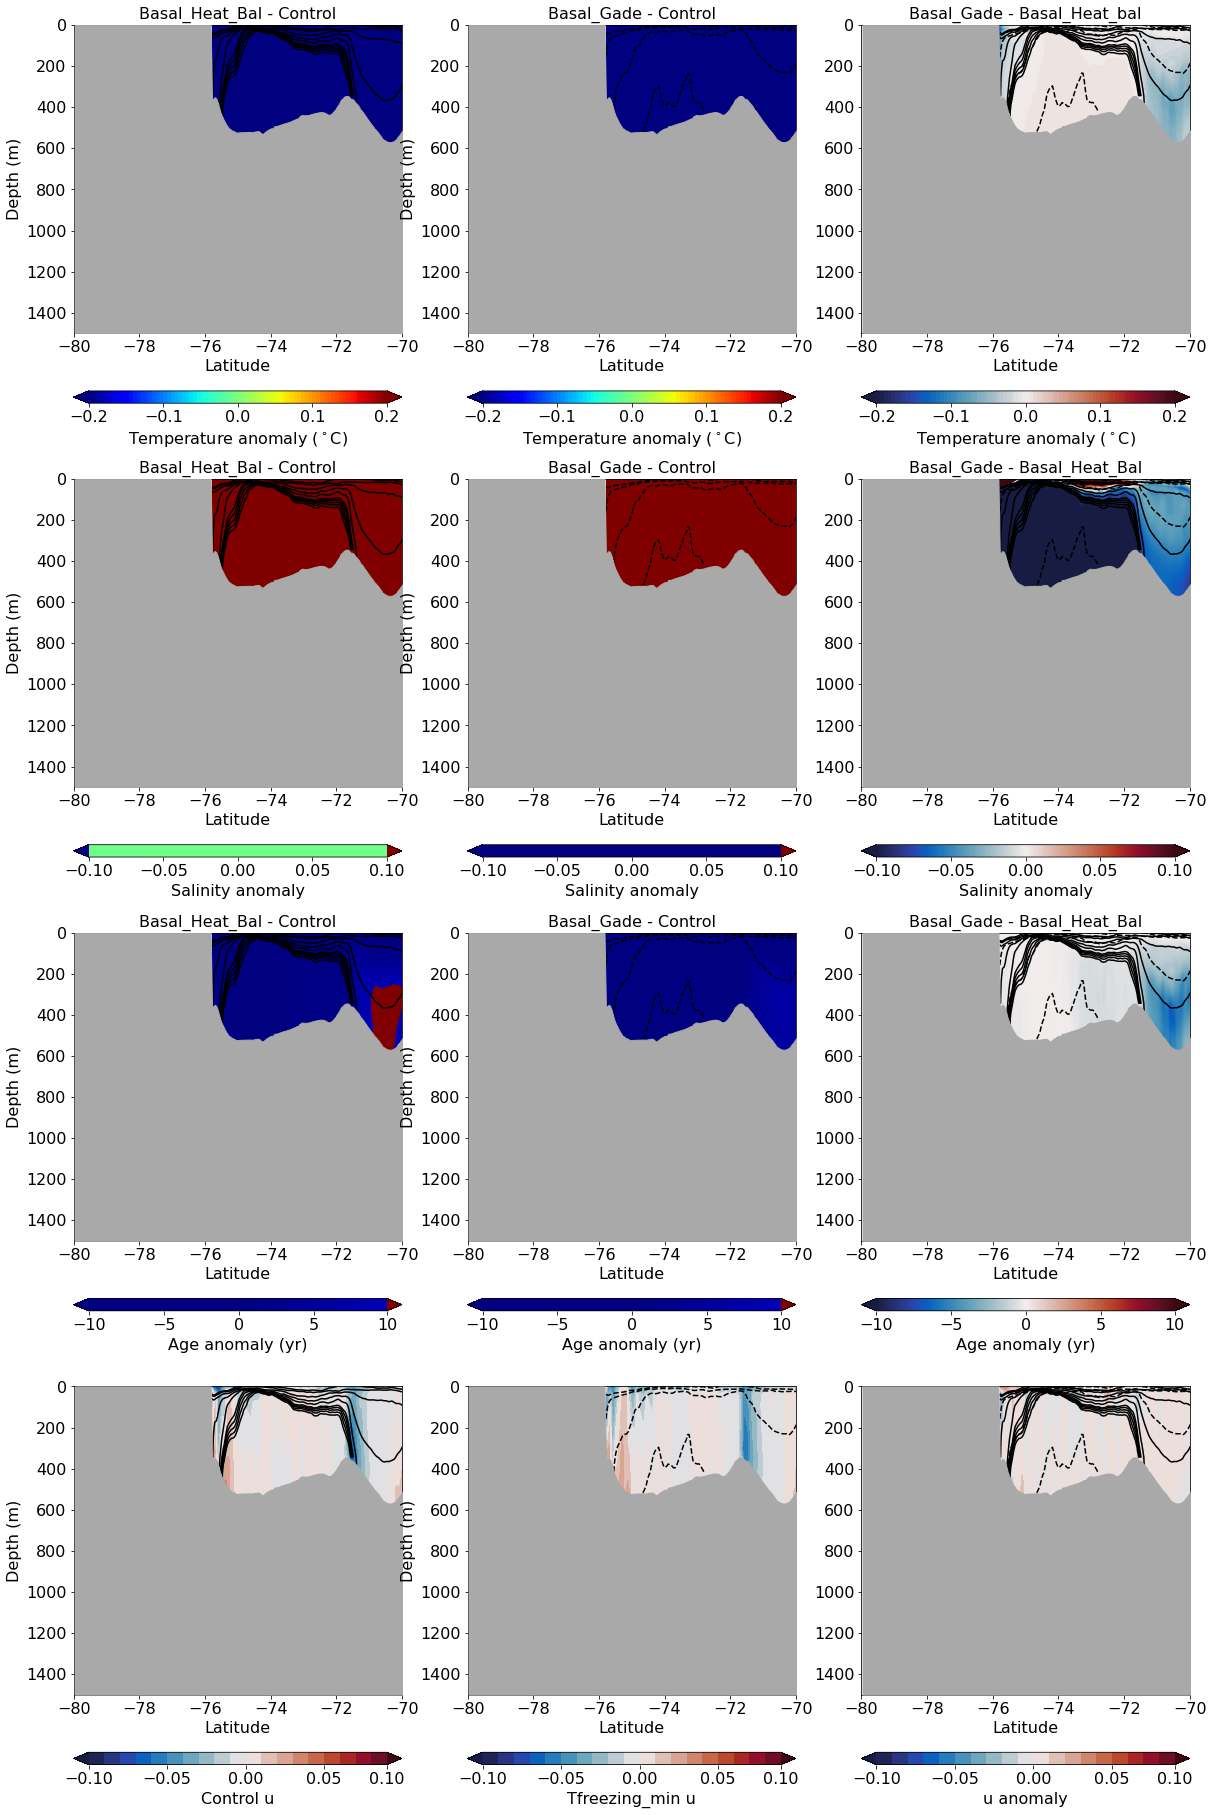

In [21]:
plot_transects('WedellE')

2022-12-16 06:42:18,990 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2022-12-16 06:42:20,218 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2022-12-16 06:42:21,813 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2022-12-16 06:42:23,424 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2022-12-16 06:42:25,328 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2022-12-16 06:42:26,451 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2022-12-16 06:42:27,825 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2022-12-16 06:42:29,065 - distributed.utils_perf - WARNING - full garbage collections took

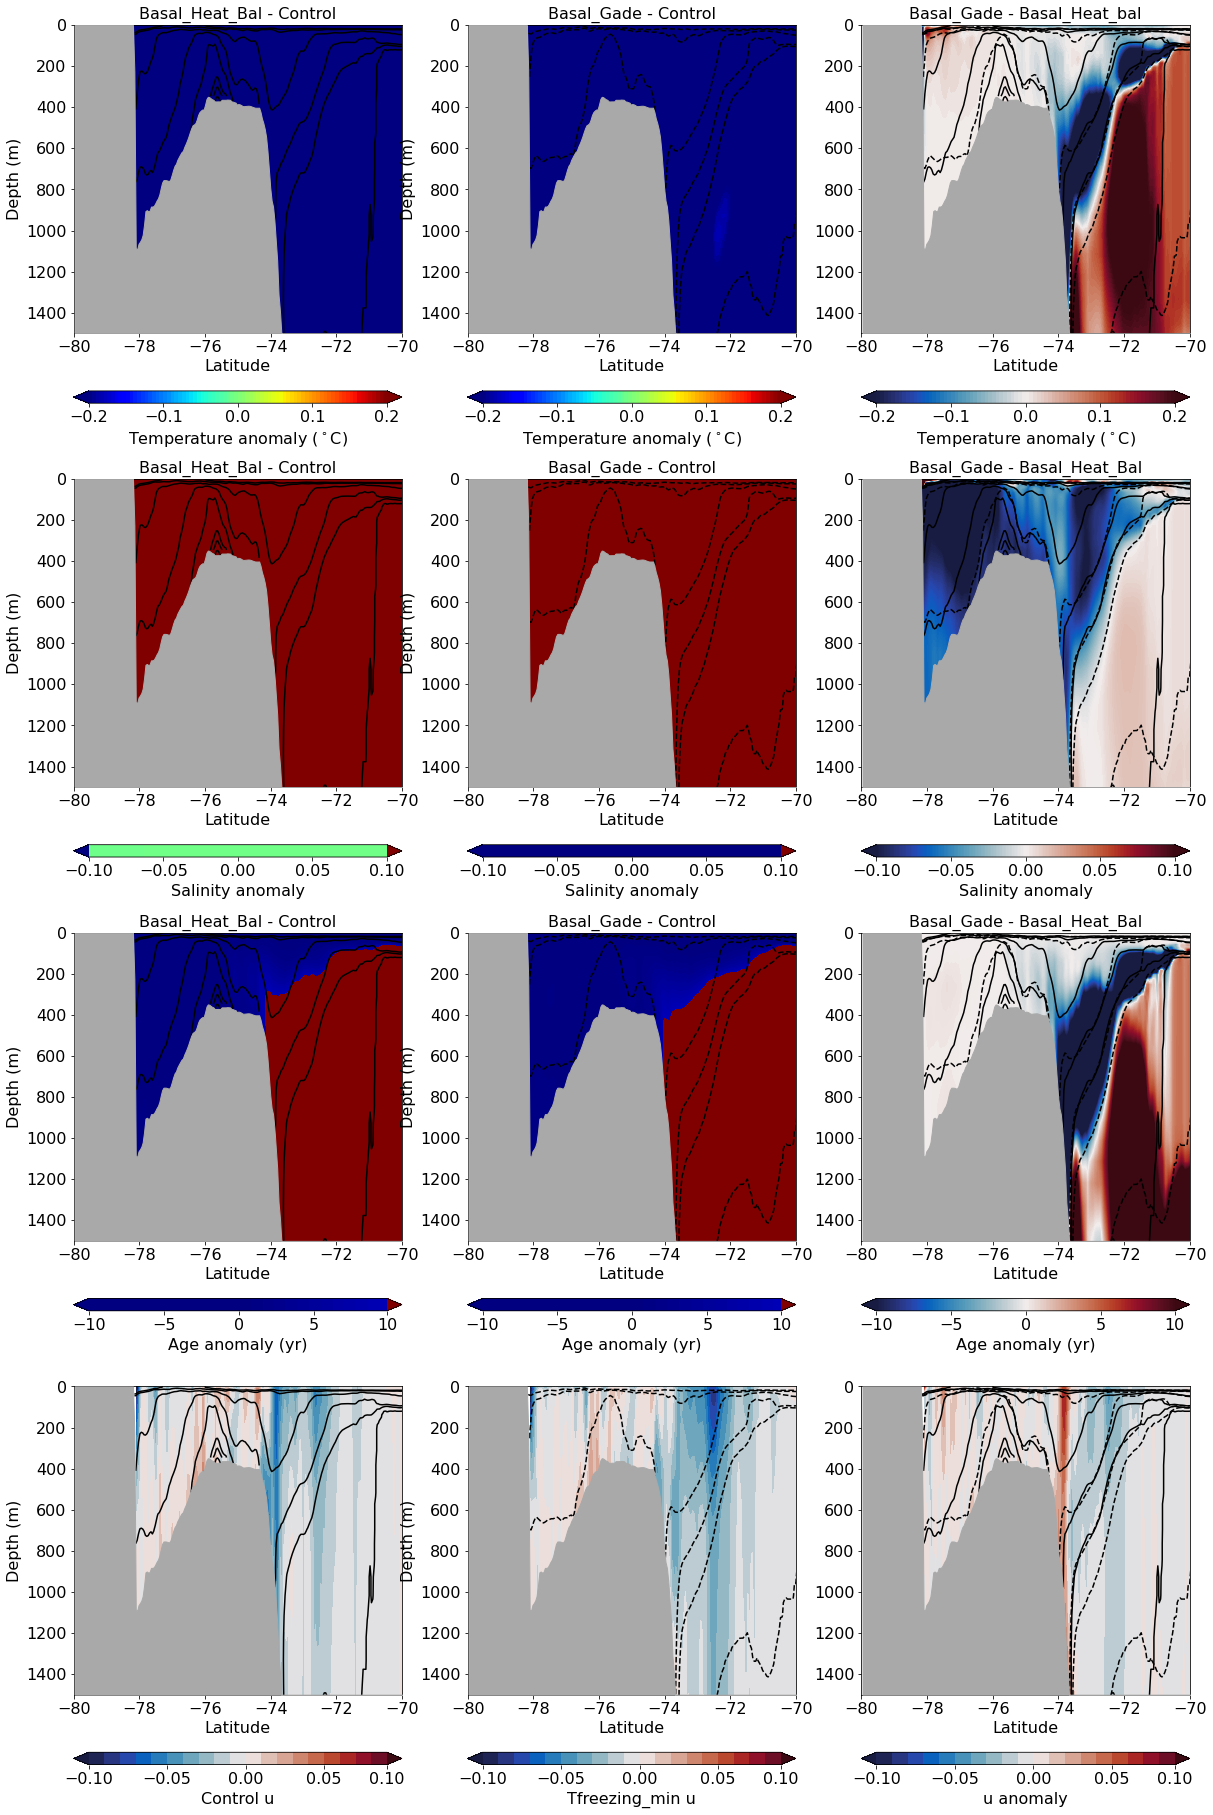

In [22]:
plot_transects('WedellW')

2022-12-16 06:42:37,438 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2022-12-16 06:42:39,829 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2022-12-16 06:42:41,487 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2022-12-16 06:42:44,620 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2022-12-16 06:42:45,572 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2022-12-16 06:42:46,789 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2022-12-16 06:42:48,340 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2022-12-16 06:42:49,535 - distributed.utils_perf - WARNING - full garbage collections took

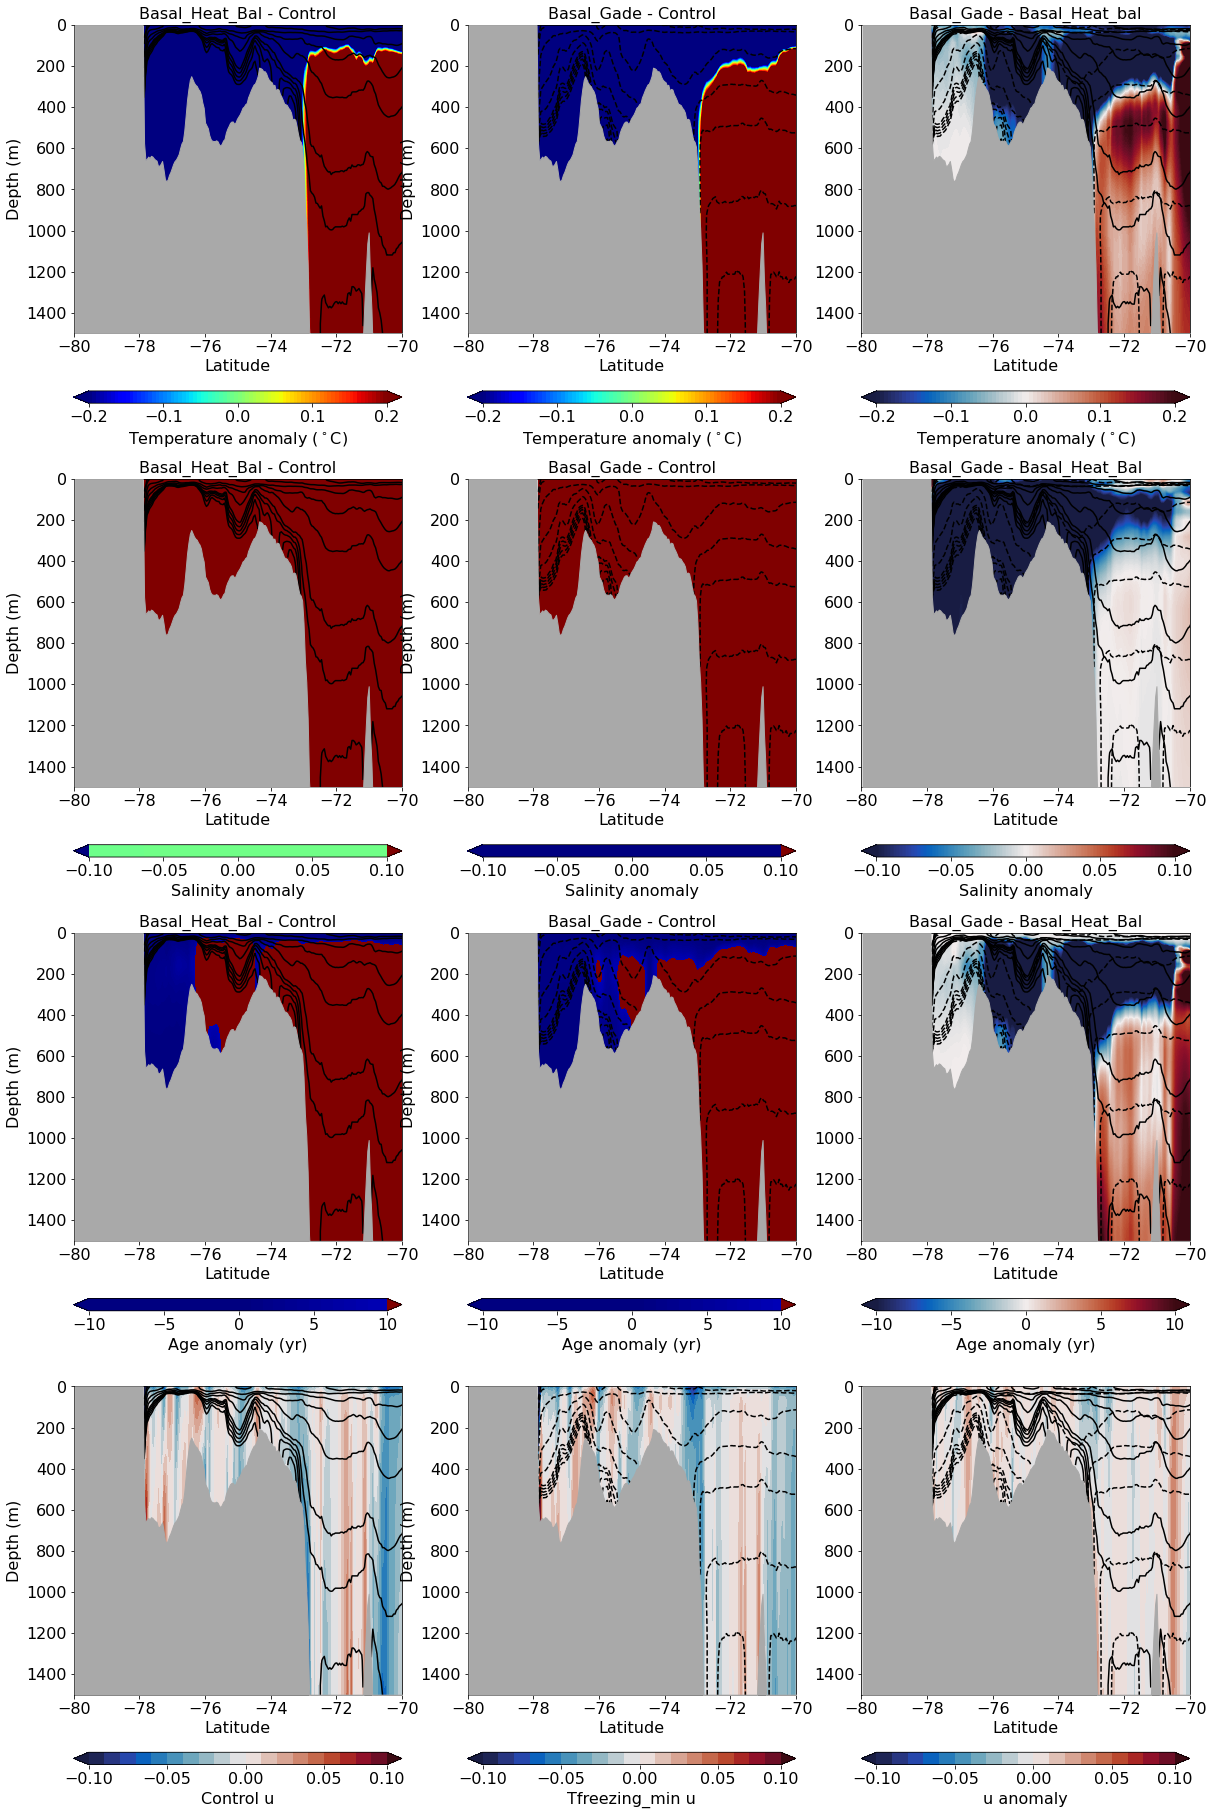

In [23]:
plot_transects('Ross')

2022-12-16 06:42:57,853 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2022-12-16 06:42:58,728 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2022-12-16 06:43:00,092 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2022-12-16 06:43:00,372 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2022-12-16 06:43:01,268 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2022-12-16 06:43:04,603 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2022-12-16 06:43:04,614 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2022-12-16 06:43:04,800 - distributed.utils_perf - WARNING - full garbage collections took

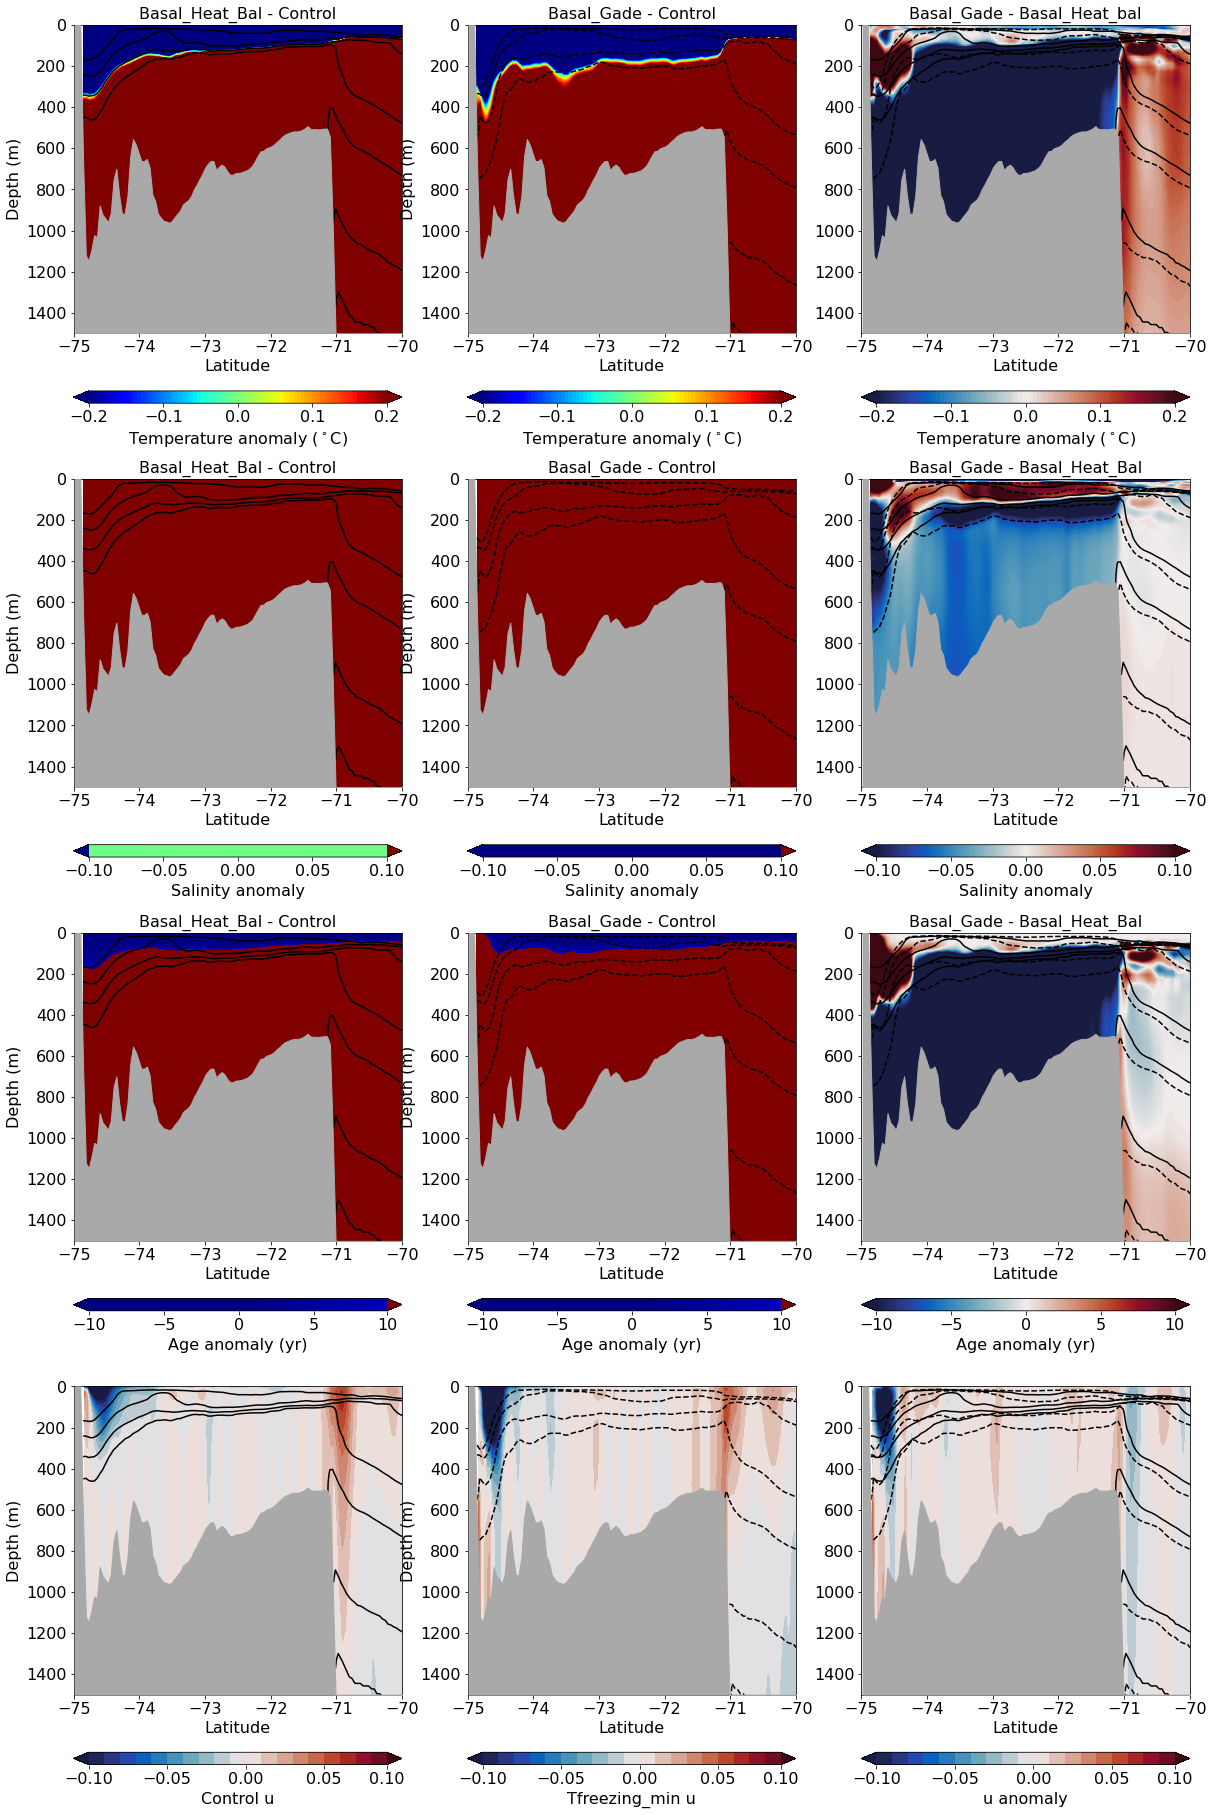

In [24]:
plot_transects('AmundsenE')

2022-12-16 06:43:15,870 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2022-12-16 06:43:18,355 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2022-12-16 06:43:19,240 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2022-12-16 06:43:19,255 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2022-12-16 06:43:19,482 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2022-12-16 06:43:23,150 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2022-12-16 06:43:23,392 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2022-12-16 06:43:24,241 - distributed.utils_perf - WARNING - full garbage collections took

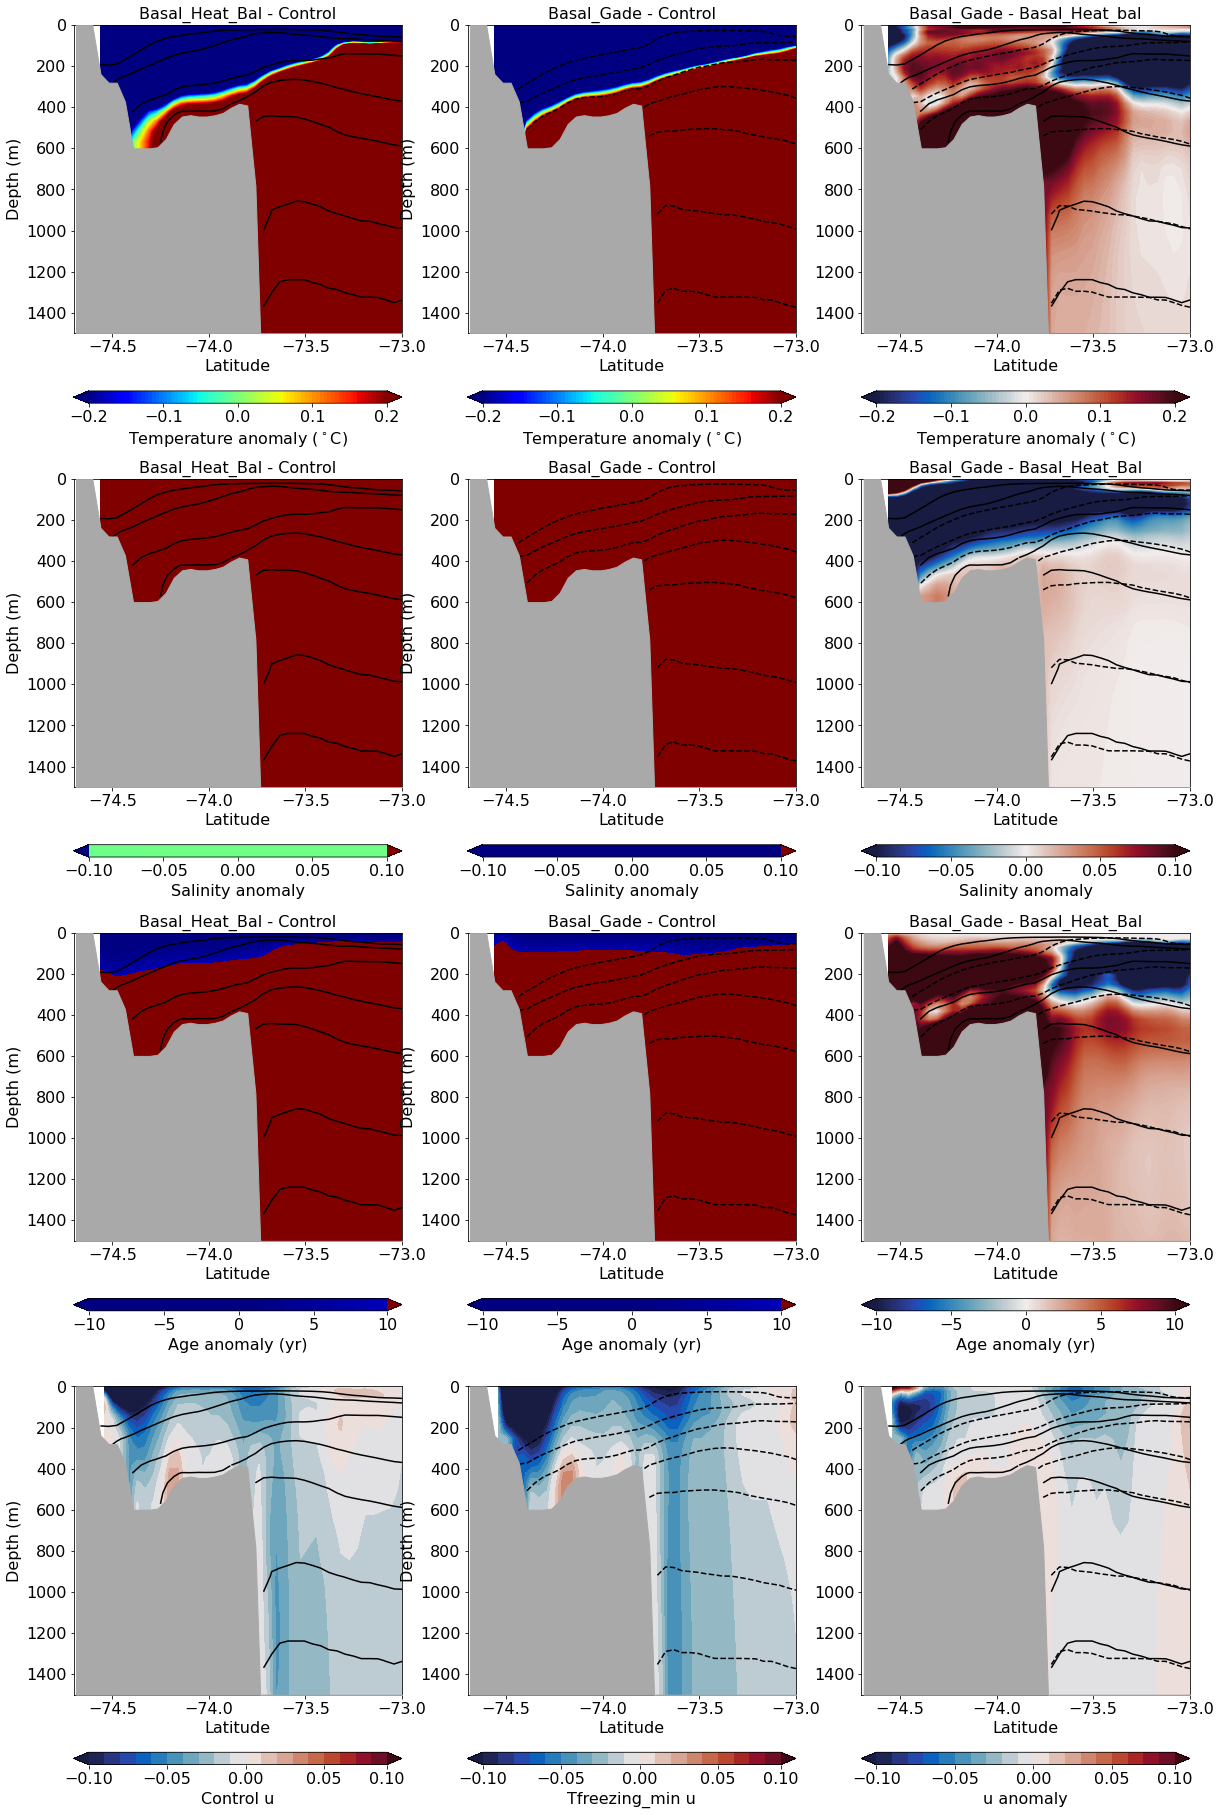

In [25]:
plot_transects('AmundsenW')

2022-12-16 06:43:33,552 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2022-12-16 06:43:33,568 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2022-12-16 06:43:33,975 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2022-12-16 06:43:36,607 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2022-12-16 06:43:37,584 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2022-12-16 06:43:41,481 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2022-12-16 06:43:41,506 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2022-12-16 06:43:41,740 - distributed.utils_perf - WARNING - full garbage collections took

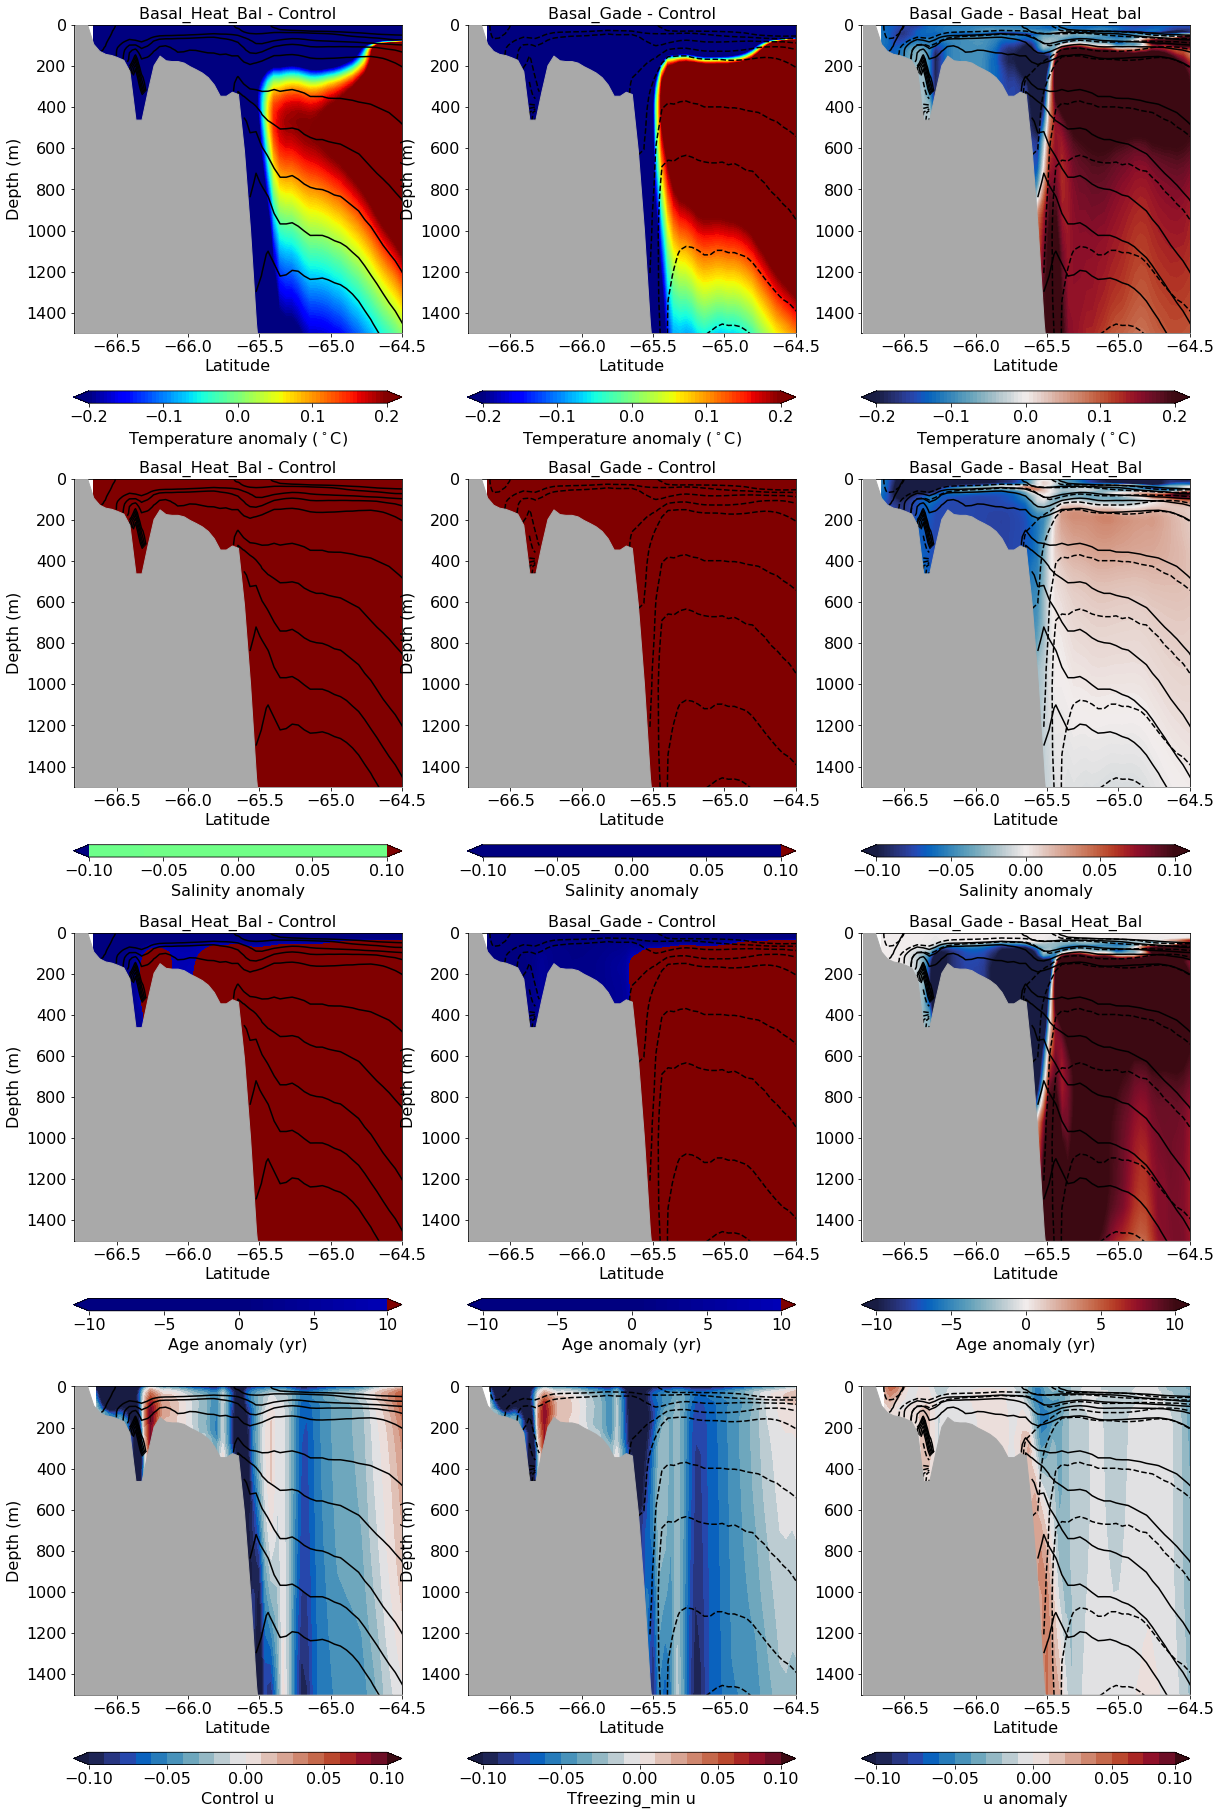

In [26]:
plot_transects('Mertz')

2022-12-16 06:43:53,226 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2022-12-16 06:43:55,061 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2022-12-16 06:43:55,297 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2022-12-16 06:43:56,522 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2022-12-16 06:43:56,765 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2022-12-16 06:43:59,652 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2022-12-16 06:44:00,331 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2022-12-16 06:44:01,285 - distributed.utils_perf - WARNING - full garbage collections took

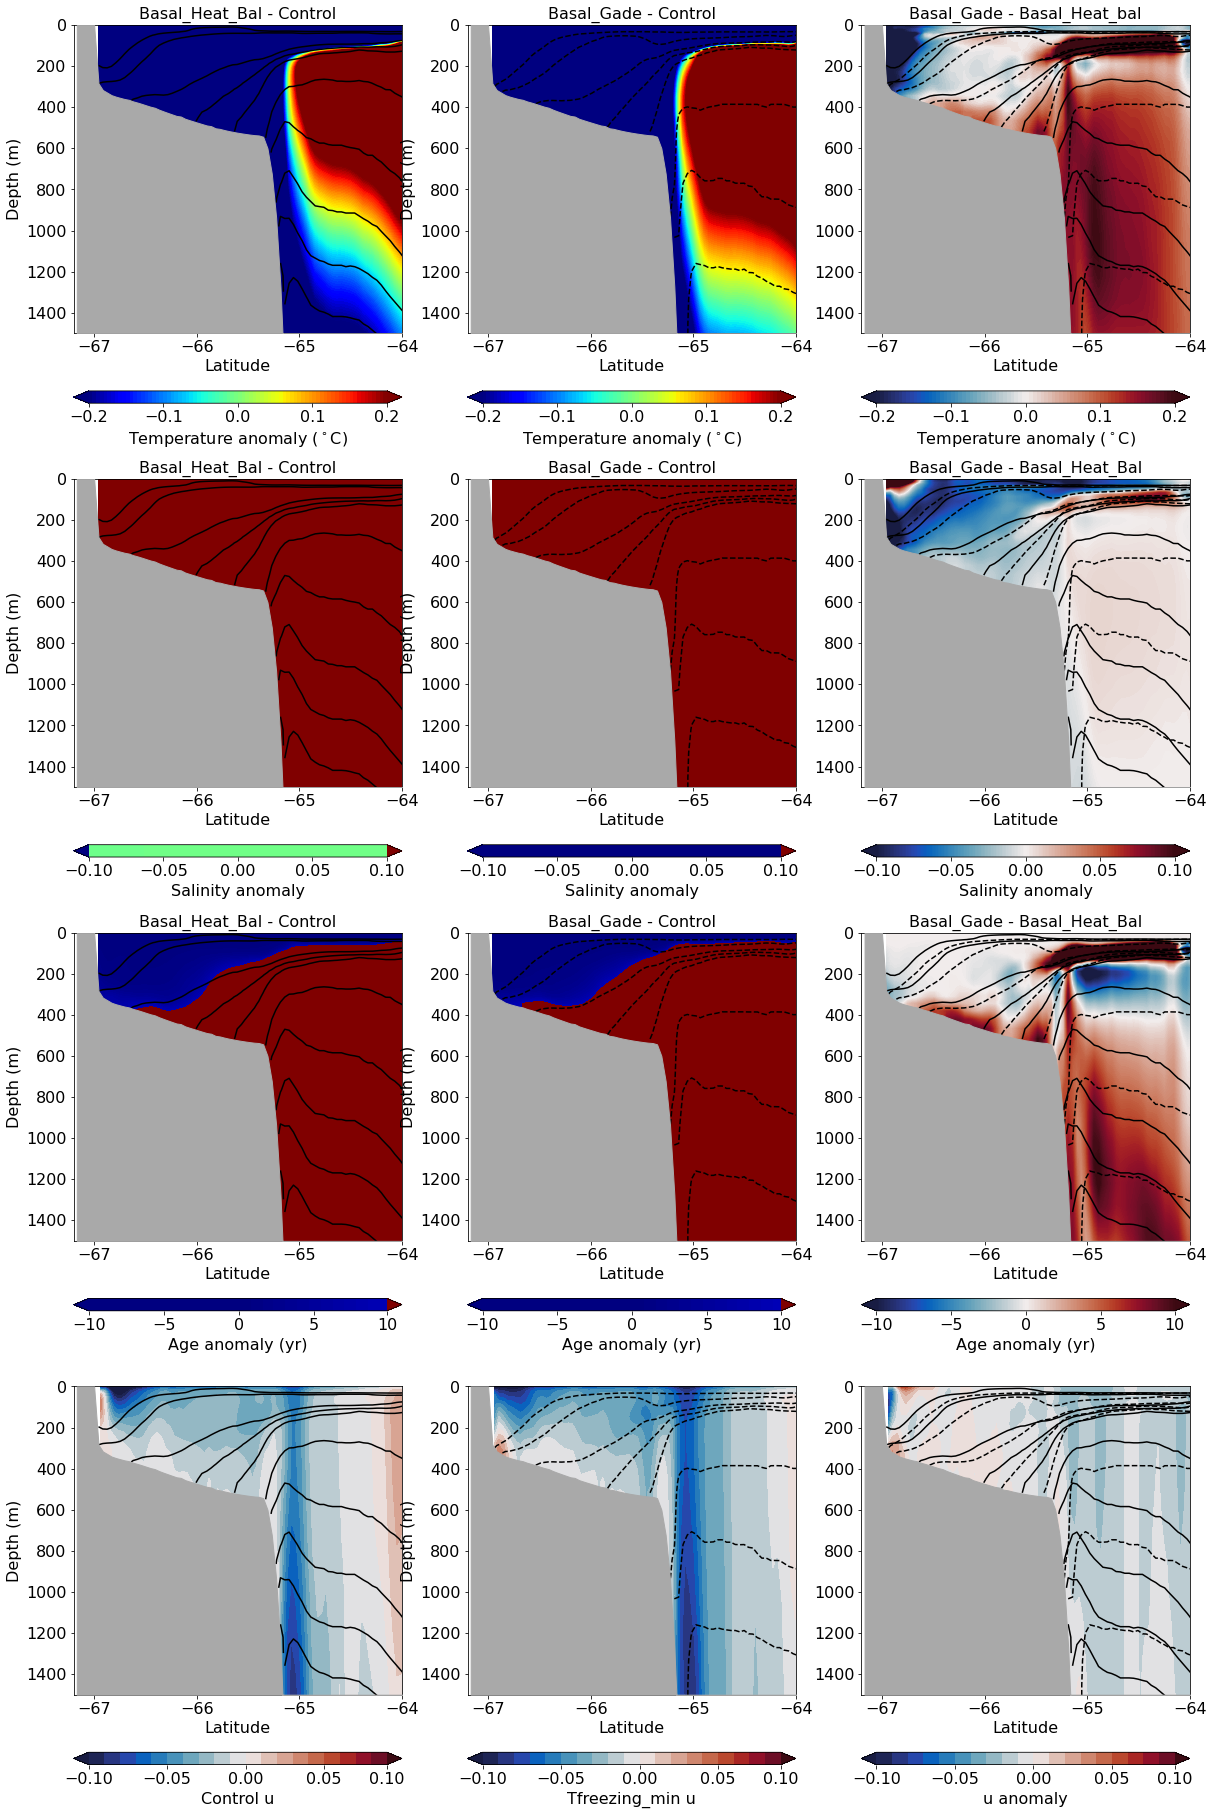

In [27]:
plot_transects('Totten')

2022-12-16 06:44:12,162 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2022-12-16 06:44:12,171 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2022-12-16 06:44:12,504 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2022-12-16 06:44:13,001 - distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
2022-12-16 06:44:14,763 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2022-12-16 06:44:15,047 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
2022-12-16 06:44:16,264 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
2022-12-16 06:44:18,433 - distributed.utils_perf - WARNING - full garbage collections took

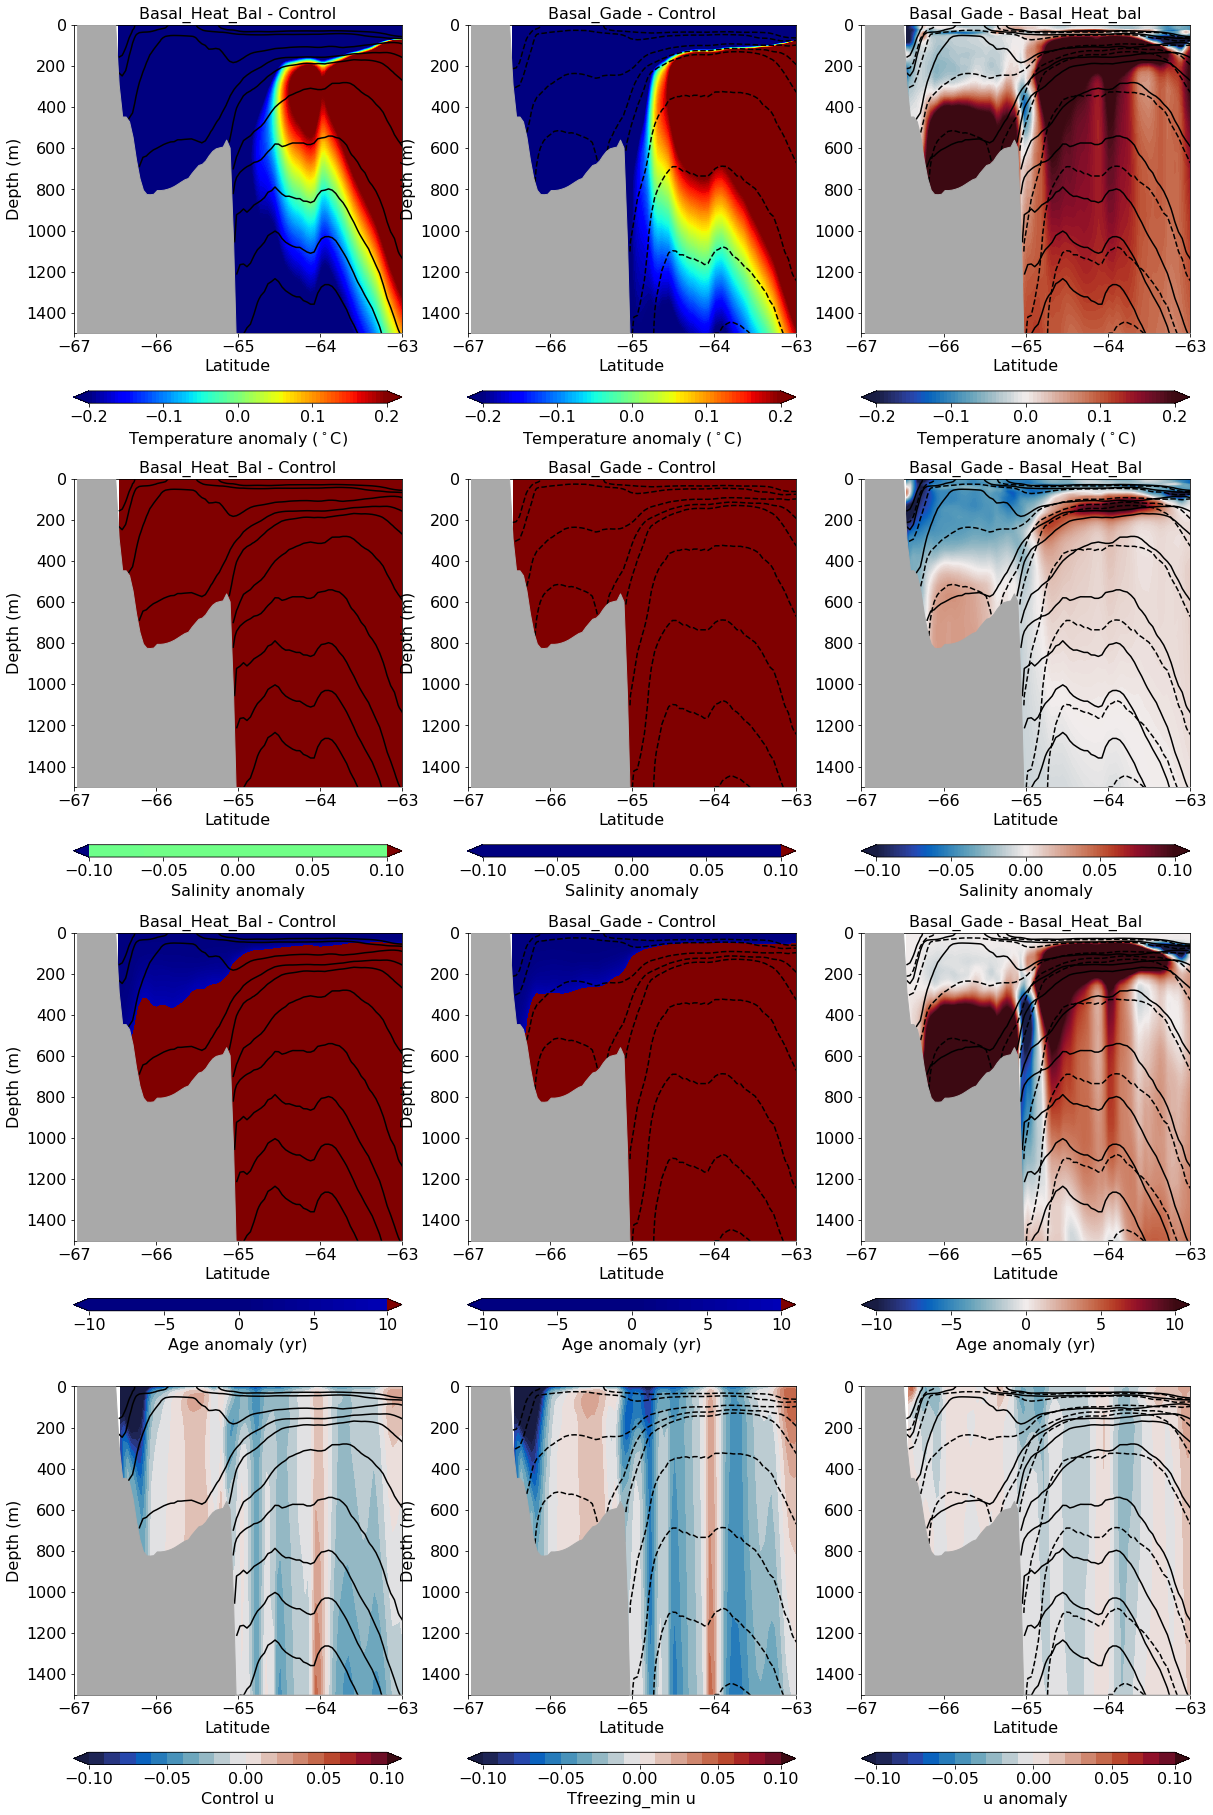

In [28]:
plot_transects('Vincennes')

2022-12-16 06:44:31,351 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2022-12-16 06:44:31,833 - distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
2022-12-16 06:44:32,710 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2022-12-16 06:44:33,701 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
2022-12-16 06:44:34,704 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2022-12-16 06:44:34,947 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
2022-12-16 06:44:36,657 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2022-12-16 06:44:38,741 - distributed.utils_perf - WARNING - full garbage collections took

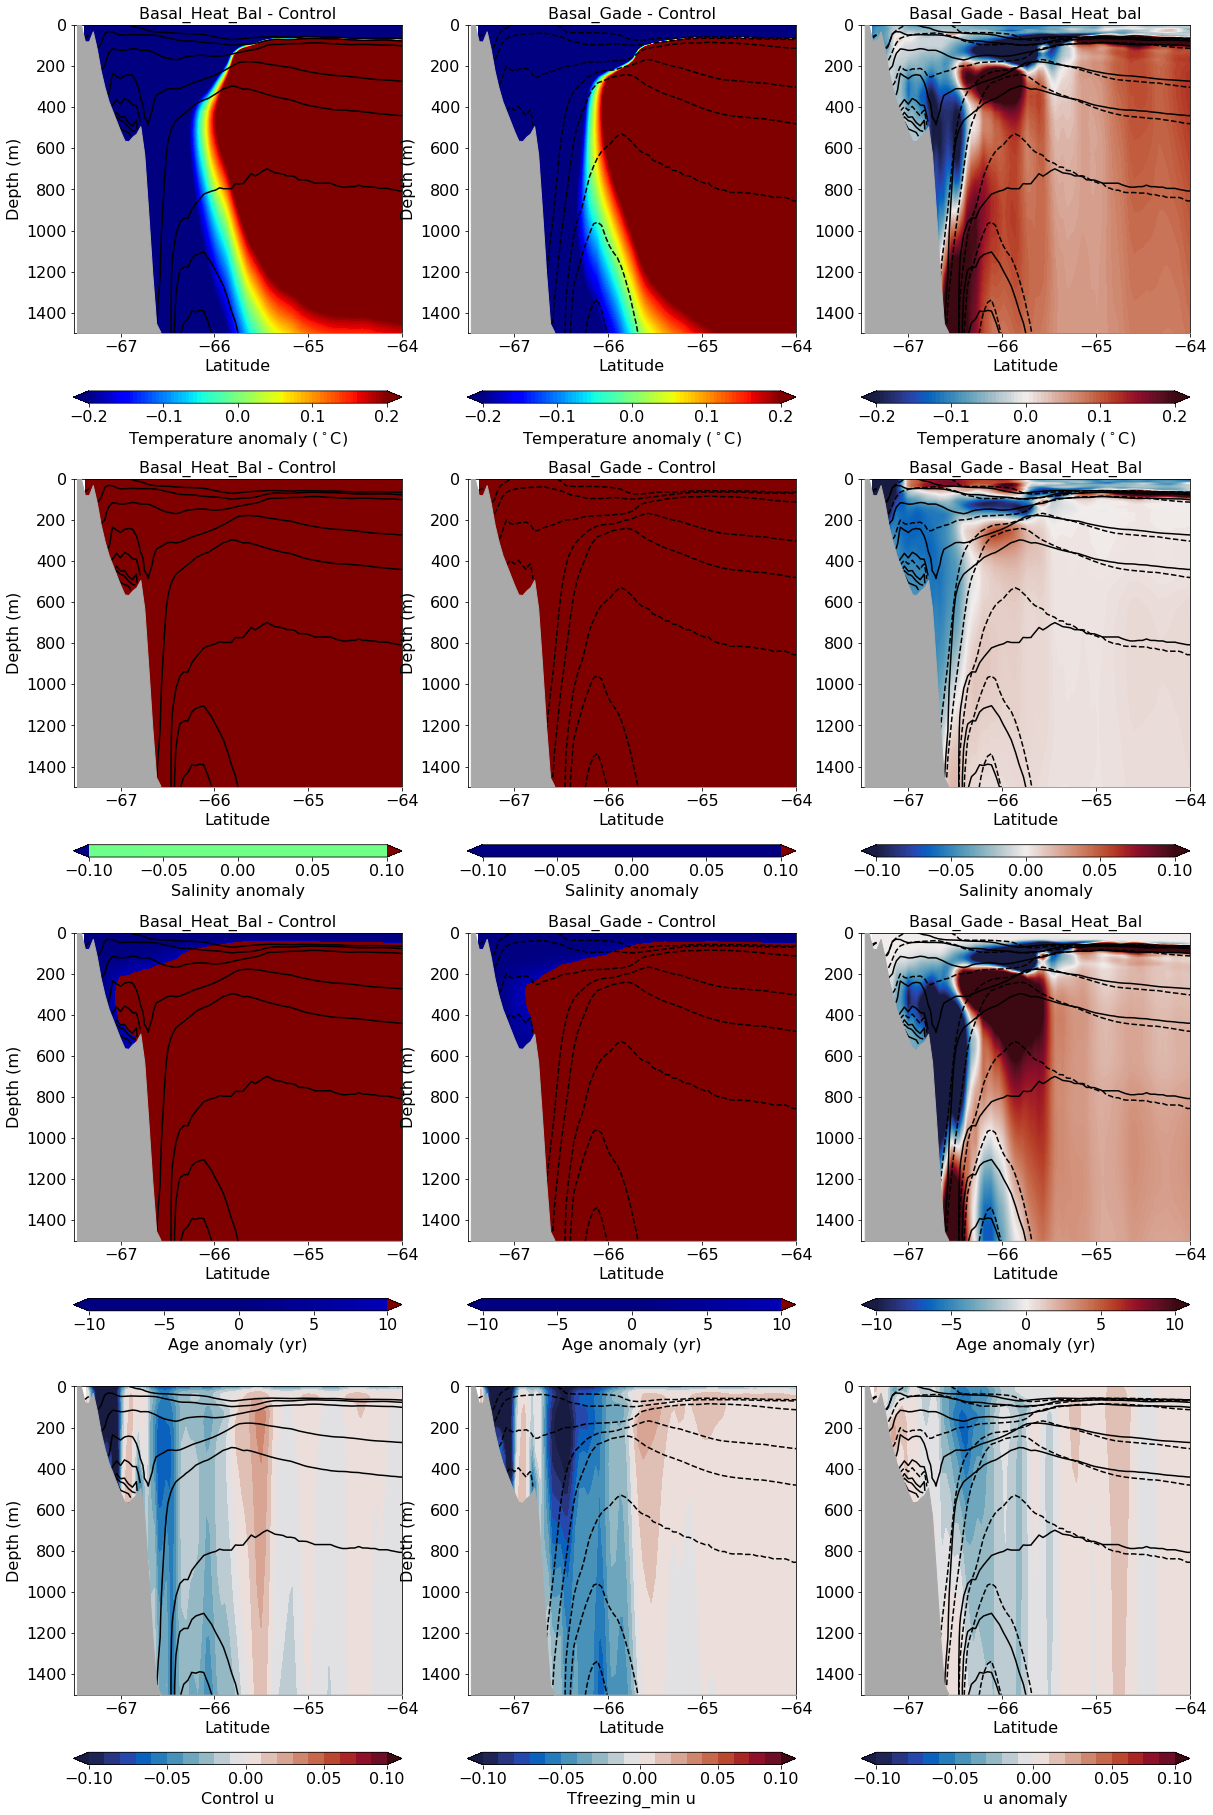

In [29]:
plot_transects('PrydzE')

2022-12-16 06:44:51,145 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2022-12-16 06:44:51,570 - distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
2022-12-16 06:44:52,816 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2022-12-16 06:44:53,962 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2022-12-16 06:44:54,214 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2022-12-16 06:44:55,337 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2022-12-16 06:44:55,360 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2022-12-16 06:44:55,580 - distributed.utils_perf - WARNING - full garbage collections took

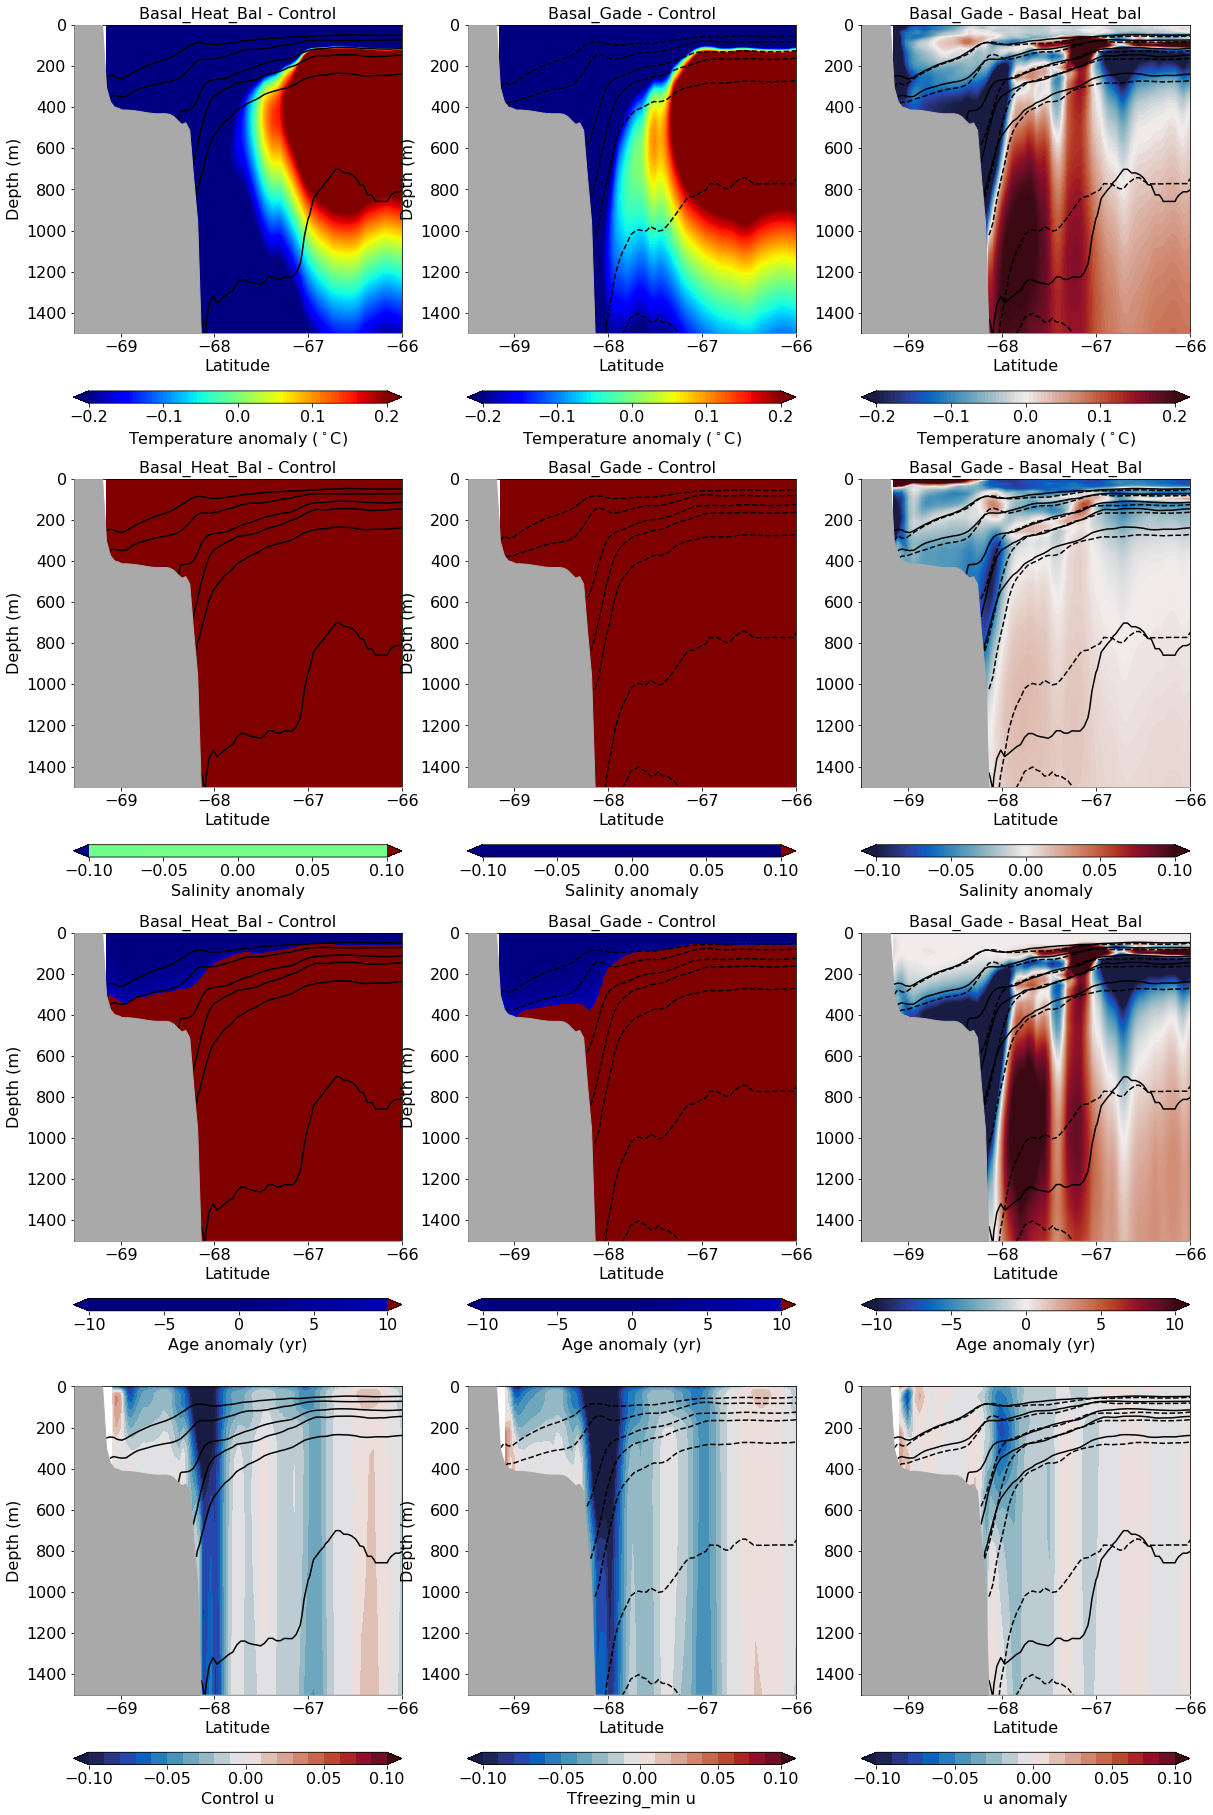

In [30]:
plot_transects('PrydzW')